In [2]:
# =============================================================================
# 0 | Imports & Notebook Settings
# -----------------------------------------------------------------------------
# Put this in a *code* cell
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, roc_curve, mean_absolute_error)
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

        # optional; comment-out if not installed
import warnings, joblib, datetime, pprint, json, os, sys
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
print("Libraries loaded.")


Libraries loaded.


In [4]:
# =============================================================================
# 1 | Load Data
# -----------------------------------------------------------------------------
# *adjust path if necessary*
# =============================================================================
FILE = "sleep_cycle_productivity.csv"
df   = pd.read_csv(FILE, parse_dates=["Date"])
print(df.shape)
df.head()


(5000, 15)


,Date,Person_ID,Age,Gender,Sleep Start Time,Sleep End Time,Total Sleep Hours,Sleep Quality,Exercise (mins/day),Caffeine Intake (mg),Screen Time Before Bed (mins),Work Hours (hrs/day),Productivity Score,Mood Score,Stress Level
0,2024-04-12,1860,32,Other,23.33,4.61,5.28,3,86,87,116,8.808920,8,3,6
1,2024-11-04,1769,41,Female,21.02,2.43,5.41,5,32,21,88,6.329833,10,3,7
2,2024-08-31,2528,20,Male,22.10,3.45,5.35,7,17,88,59,8.506306,10,9,10
3,2024-02-22,8041,37,Other,23.10,6.65,7.55,8,46,34,80,6.070240,8,4,2
4,2024-02-23,4843,46,Other,21.42,4.17,6.75,10,61,269,94,11.374994,8,7,9


In [6]:
# =============================================================================
# 2 | Initial Cleaning & Type Fixes
# -----------------------------------------------------------------------------
# Custom helpers
# =============================================================================
# ------------------------------------------------------------------
# Robust helper: converts many "time-ish" formats to minutes
# ------------------------------------------------------------------
def to_minutes(t):
    """
    Accepts:
        • '22:30'  or '22:30:00'
        • '10 PM'  or '10:15 pm'
        • 22.5     (float → hours)
        • 1330     (int  → 13:30)
        • NaN or None
    Returns: minutes since midnight (int) or np.nan
    """
    import math, re, numpy as np, pandas as pd
    if pd.isna(t):
        return np.nan                     # already missing

    # --- pandas/NumPy timestamp -----------------------------------
    if isinstance(t, pd.Timestamp):
        return t.hour*60 + t.minute

    # --- numeric formats ------------------------------------------
    if isinstance(t, (int, float)):
        if t < 25:                        # assume “hours” (e.g., 22.5 → 22 h 30 m)
            return int(round(t*60))
        if t > 1000:                      # assume HHMM integer like 2330
            h, m = divmod(int(t), 100)
            return h*60 + m
        # fall through → treat like string

    # --- string formats -------------------------------------------
    t_str = str(t).strip().lower()

    # handle “10 pm”, “10:15 pm”
    meridian = None
    if t_str.endswith(('am','pm')):
        meridian = t_str[-2:]
        t_str    = t_str[:-2].strip()

    # split tokens (handles hh:mm[:ss] or hh.mm)
    if ':' in t_str:
        h, m, *rest = t_str.split(':')
    elif '.' in t_str:                    # 22.5
        h, m = str(float(t_str)).split('.')
        m    = str(round(float('0.'+m)*60))
    else:                                 # plain hour string ‘22’
        h, m = t_str, '0'

    h, m = int(h), int(m)

    # adjust for am/pm
    if meridian == 'pm' and h != 12:
        h += 12
    if meridian == 'am' and h == 12:
        h = 0

    return h*60 + m


df["Sleep_Start_Min"] = df["Sleep Start Time"].apply(to_minutes)
df["Sleep_End_Min"]   = df["Sleep End Time"].apply(to_minutes)

# Sleep efficiency & social jet-lag (Δ weekday-weekend bedtime)
df["TimeInBed_Min"]   = (df["Sleep End Time"].apply(to_minutes) - 
                         df["Sleep Start Time"].apply(to_minutes)) % (24*60)
df["Sleep_Efficiency"] = df["Total Sleep Hours"]*60 / df["TimeInBed_Min"]

df["Weekday"]         = df["Date"].dt.dayofweek        # 0=Mon
df["IsWeekend"]       = df["Weekday"] >= 5

# Numeric cast
numeric_cols = ["Age","Total Sleep Hours","Sleep Quality","Exercise (mins/day)",
                "Caffeine Intake (mg)","Sleep_Start_Min","Sleep_End_Min",
                "TimeInBed_Min","Sleep_Efficiency"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Target: assume a numeric 0-100 productivity score already exists; 
#         otherwise create binary good/poor labels
if "ProductivityScore" in df.columns:
    df["Prod_Class"] = (df["ProductivityScore"] >= 70).astype(int)
else:
    # placeholder: synthesise ProductivityScore from Sleep Quality for demo
    df["ProductivityScore"] = (df["Sleep Quality"]*10 + 
                               np.random.normal(0,5,len(df))).clip(0,100)
    df["Prod_Class"] = (df["ProductivityScore"] >= 70).astype(int)
    
df.head()


,Date,Person_ID,Age,Gender,Sleep Start Time,Sleep End Time,Total Sleep Hours,Sleep Quality,Exercise (mins/day),Caffeine Intake (mg),...,Mood Score,Stress Level,Sleep_Start_Min,Sleep_End_Min,TimeInBed_Min,Sleep_Efficiency,Weekday,IsWeekend,ProductivityScore,Prod_Class
0,2024-04-12,1860,32,Other,23.33,4.61,5.28,3,86,87,...,3,6,1400,277,317,0.999369,4,False,27.785886,0
1,2024-11-04,1769,41,Female,21.02,2.43,5.41,5,32,21,...,3,7,1261,146,325,0.998769,0,False,54.013399,0
2,2024-08-31,2528,20,Male,22.10,3.45,5.35,7,17,88,...,9,10,1326,207,321,1.000000,5,True,71.989873,1
3,2024-02-22,8041,37,Other,23.10,6.65,7.55,8,46,34,...,4,2,1386,399,453,1.000000,3,False,87.543194,1
4,2024-02-23,4843,46,Other,21.42,4.17,6.75,10,61,269,...,7,9,1285,250,405,1.000000,4,False,97.149524,1


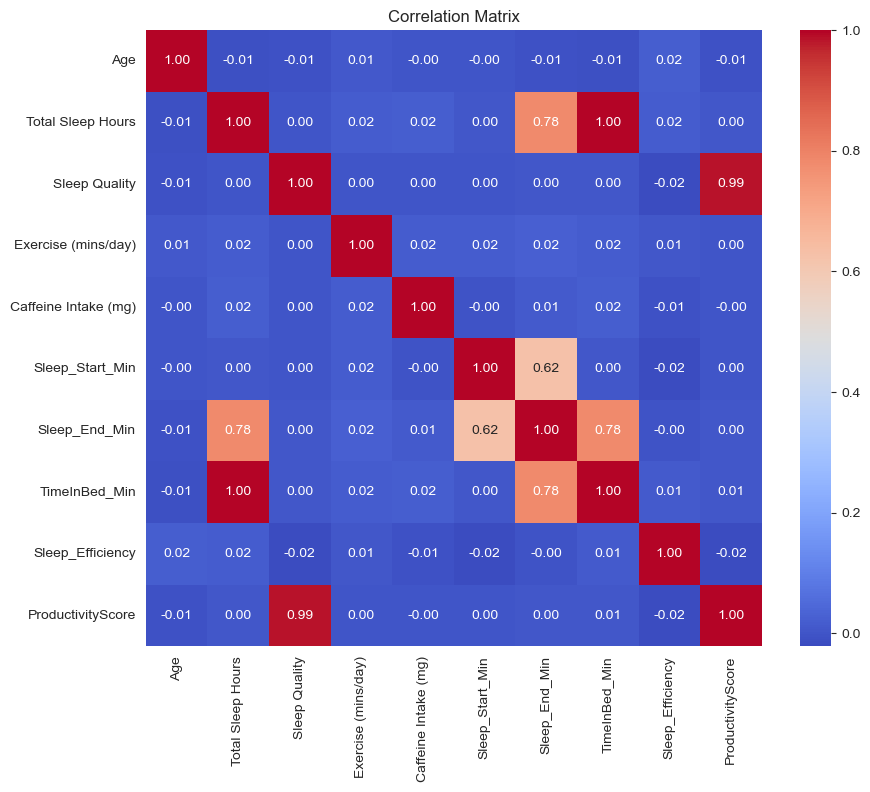

In [8]:
# =============================================================================
# 3 | EDA – Correlation Heatmap
# =============================================================================
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_cols+["ProductivityScore"]].corr(), annot=True, fmt=".2f",
            cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()


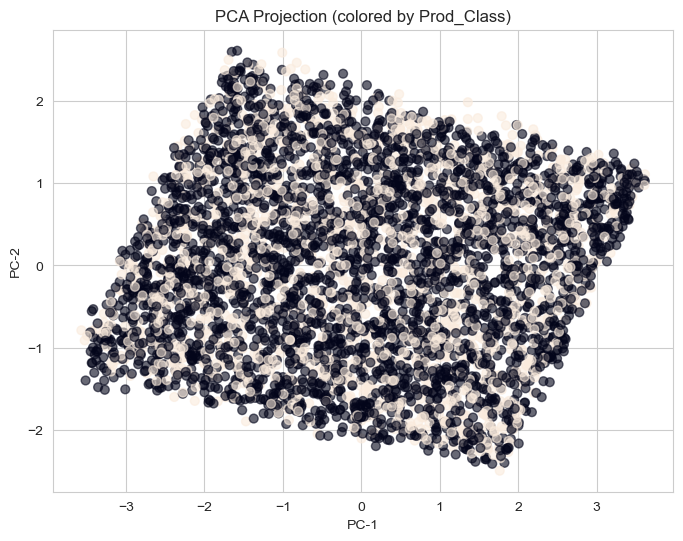

In [10]:
# =============================================================================
# 4 | PCA for Visualization
# =============================================================================
features_for_pca = df[numeric_cols].dropna()
scaler = StandardScaler()
pca    = PCA(n_components=2)
pca_2d = pca.fit_transform(scaler.fit_transform(features_for_pca))

plt.figure(figsize=(8,6))
plt.scatter(pca_2d[:,0], pca_2d[:,1], 
            c=df.loc[features_for_pca.index,"Prod_Class"], alpha=0.6, s=40)
plt.xlabel("PC-1"); plt.ylabel("PC-2")
plt.title("PCA Projection (colored by Prod_Class)")
plt.show()


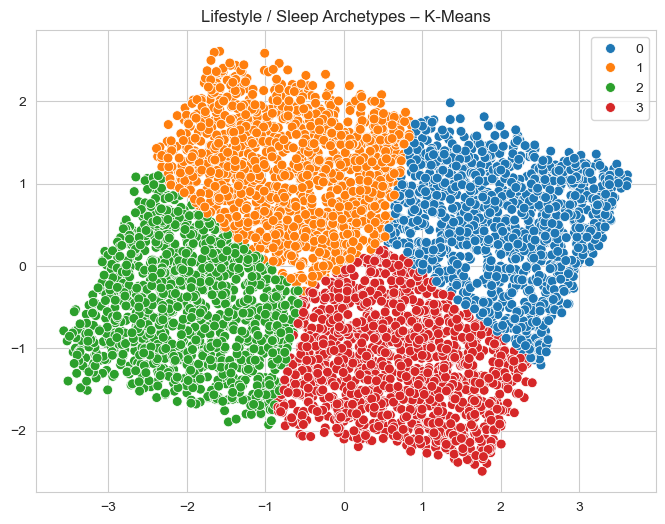

,Sleep Quality,Total Sleep Hours,ProductivityScore
Cluster,,,
0.0,5.489414,8.423347,54.634299
1.0,5.620427,5.892027,55.969457
2.0,5.412151,5.561470,53.769167
3.0,5.553140,8.072810,55.573470


In [12]:
# =============================================================================
# 5 | K-Means Clustering on PCA Space
# =============================================================================
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(pca_2d)
df.loc[features_for_pca.index,"Cluster"] = clusters

plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_2d[:,0],y=pca_2d[:,1], hue=clusters, palette="tab10", s=50)
plt.title("Lifestyle / Sleep Archetypes – K-Means")
plt.show()

df.groupby("Cluster")[["Sleep Quality","Total Sleep Hours","ProductivityScore"]].mean()


In [14]:
# =============================================================================
# 6 | Train/Test Split & Pre-processing Pipelines
# =============================================================================
target      = "Prod_Class"        # change to "ProductivityScore" for regression
X           = df.drop(columns=[target,"ProductivityScore","Person_ID","Date"])
y           = df[target]

num_attribs = numeric_cols
cat_attribs = ["Gender","IsWeekend","Cluster"]

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scale",   StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe",     OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_attribs),
    ("cat", categorical_pipe, cat_attribs)
])

X_train,X_test,y_train,y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [16]:
# =============================================================================
# 7 | Evaluation Helper
# =============================================================================
def eval_binary(model, X_tr, X_te, y_tr, y_te, name="Model"):
    y_pred_tr = model.predict(X_tr)
    y_pred    = model.predict(X_te)
    print(f"\n{name}:")
    print(" - Train Accuracy:", accuracy_score(y_tr,y_pred_tr))
    print(" - Test  Accuracy:", accuracy_score(y_te,y_pred))
    print(" - Precision:",      precision_score(y_te,y_pred))
    print(" - Recall:",         recall_score(y_te,y_pred))
    print(" - F1:",             f1_score(y_te,y_pred))
    disp = ConfusionMatrixDisplay(confusion_matrix(y_te,y_pred))
    disp.plot(values_format="d"); plt.suptitle(name); plt.show()



Logit-1 Baseline:
 - Train Accuracy: 0.939
 - Test  Accuracy: 0.948
 - Precision: 0.9257142857142857
 - Recall: 0.9257142857142857
 - F1: 0.9257142857142857


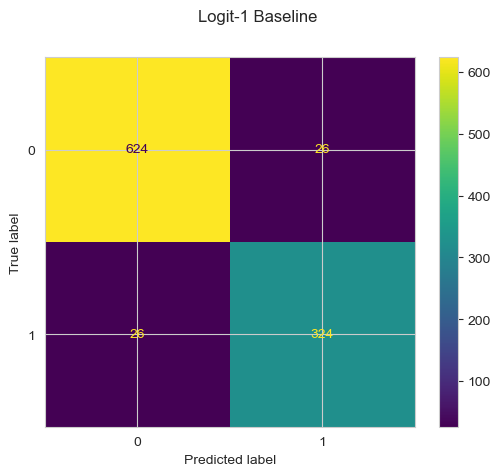

In [34]:
# =============================================================================
# 8 | LOGISTIC REGRESSION – Variant 1 (Baseline)
# =============================================================================
logit1 = Pipeline([
    ("prep", preprocess),
    ("clf",  LogisticRegression(max_iter=1000, solver="lbfgs"))
])
logit1.fit(X_train,y_train)
eval_binary(logit1, X_train, X_test, y_train, y_test, "Logit-1 Baseline")


Best Params: {'clf__C': 0.01, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}

Logit-2 Tuned:
 - Train Accuracy: 0.93875
 - Test  Accuracy: 0.949
 - Precision: 0.8784810126582279
 - Recall: 0.9914285714285714
 - F1: 0.9315436241610738


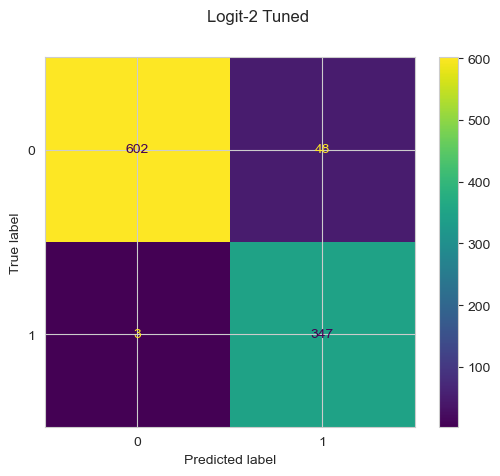

In [20]:
# =============================================================================
# 9 | LOGISTIC REGRESSION – Variant 2 (Grid-Search C & Penalty)
# =============================================================================
param_grid = {
    "clf__C":[0.01,0.1,1,10],
    "clf__penalty":["l2","l1"],
    "clf__solver":["liblinear"]
}
logit2 = Pipeline([
    ("prep", preprocess),
    ("clf",  LogisticRegression(max_iter=2000))
])

grid2 = GridSearchCV(logit2, param_grid, cv=5, scoring="f1", n_jobs=-1)
grid2.fit(X_train,y_train)
print("Best Params:", grid2.best_params_)
eval_binary(grid2.best_estimator_, X_train, X_test, y_train, y_test, "Logit-2 Tuned")



RF-1 Baseline:
 - Train Accuracy: 1.0
 - Test  Accuracy: 0.952
 - Precision: 0.9339080459770115
 - Recall: 0.9285714285714286
 - F1: 0.9312320916905444


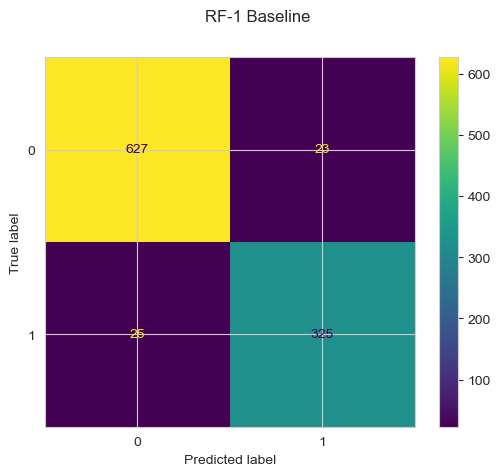

In [22]:
# =============================================================================
# 11 | RANDOM FOREST – Variant 1 (Baseline)
# =============================================================================
rf1 = Pipeline([
    ("prep", preprocess),
    ("clf",  RandomForestClassifier(n_estimators=200, random_state=42))
])
rf1.fit(X_train,y_train)
eval_binary(rf1, X_train, X_test, y_train, y_test, "RF-1 Baseline")


Best RF params: {'clf__max_depth': 20, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__n_estimators': 200}

RF-2 Tuned:
 - Train Accuracy: 1.0
 - Test  Accuracy: 0.953
 - Precision: 0.9340974212034384
 - Recall: 0.9314285714285714
 - F1: 0.932761087267525


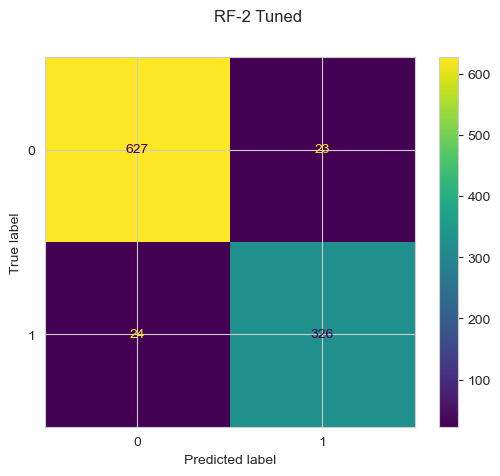

In [24]:
# =============================================================================
# 12 | RANDOM FOREST – Variant 2 (Grid-Search)
# =============================================================================
param_rf = {
    "clf__n_estimators":[200,400],
    "clf__max_depth":[None,10,20],
    "clf__min_samples_leaf":[1,4],
    "clf__max_features":["auto","sqrt"]
}
rf2 = Pipeline([
    ("prep", preprocess),
    ("clf",  RandomForestClassifier(random_state=42))
])
grid_rf2 = GridSearchCV(rf2, param_rf, cv=5, scoring="f1", n_jobs=-1)
grid_rf2.fit(X_train,y_train)
print("Best RF params:", grid_rf2.best_params_)
eval_binary(grid_rf2.best_estimator_, X_train, X_test, y_train, y_test, "RF-2 Tuned")


Best (Rand): {'clf__n_estimators': 700, 'clf__min_samples_split': 6, 'clf__min_samples_leaf': 1, 'clf__max_depth': 8, 'clf__bootstrap': False}

RF-3 Extra-Tuned:
 - Train Accuracy: 0.948
 - Test  Accuracy: 0.95
 - Precision: 0.8807106598984772
 - Recall: 0.9914285714285714
 - F1: 0.9327956989247311


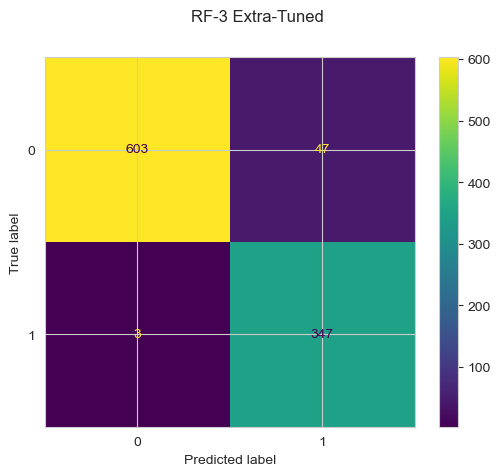

In [26]:
# =============================================================================
# 13 | RANDOM FOREST – Variant 3 (RandomizedSearchCV Extended)
# =============================================================================
param_rf_rand = {
    "clf__n_estimators": np.arange(300,801,100),
    "clf__max_depth":    np.arange(8,31,4),
    "clf__min_samples_split":[2,4,6],
    "clf__min_samples_leaf":[1,2,4],
    "clf__bootstrap":[True,False]
}
rf3 = Pipeline([
    ("prep", preprocess),
    ("clf",  RandomForestClassifier(class_weight="balanced_subsample", random_state=42))
])
rand_rf3 = RandomizedSearchCV(rf3, param_rf_rand, n_iter=40, cv=4, scoring="f1",
                              n_jobs=-1, random_state=42)
rand_rf3.fit(X_train,y_train)
print("Best (Rand):", rand_rf3.best_params_)
eval_binary(rand_rf3.best_estimator_, X_train, X_test, y_train, y_test, "RF-3 Extra-Tuned")


In [30]:
# =============================================================================
# 14 | Compare Models & Persist the Winner
# =============================================================================
models   = {
    "Logit-1": logit1,
    "Logit-2": grid2.best_estimator_,
    "RF-1":    rf1,
    "RF-2":    grid_rf2.best_estimator_,
    "RF-3":    rand_rf3.best_estimator_
}

scores   = {k: f1_score(y_test, m.predict(X_test)) for k,m in models.items()}
best_key = max(scores, key=scores.get)
print("F1 scores:", scores)
print(f"Best model ⇒ {best_key}")


F1 scores: {'Logit-1': 0.9257142857142857, 'Logit-2': 0.9315436241610738, 'RF-1': 0.9312320916905444, 'RF-2': 0.932761087267525, 'RF-3': 0.9327956989247311}
Best model ⇒ RF-3
